<h1 align="center">Introdução à implantação de ML: Flask, Docker e Locust</h1>

Data Scientist.: Dr.Eddy Giusepe Chirinos Isidro

Aqui aprenderemos a implantar nossos modelos em `Python` e medir o desempenho usando o [Locust](https://docs.locust.io/en/stable/what-is-locust.html#what-is-locust).

# Introdução

Você gastou muito tempo no [EDA](https://www.analyticsvidhya.com/blog/2021/04/rapid-fire-eda-process-using-python-for-ml-implementation/), elaborou cuidadosamente suas features, ajustou seu modelo por dias e, finalmente, tem algo que funciona bem no conjunto de `teste`. <font color="red">O que agora?</font> Agora, meu amigo, precisamos implantar o modelo. Afinal, qualquer modelo que fica no notebook tem valor zero, por melhor que seja.


A seguinte imagem é só para lembrar do processo de Machine Learning:


![](https://editor.analyticsvidhya.com/uploads/39379DS-flow.png)


Na preparação de Dados, a EDA, muitas vezes demanda muito tempo já que precisamos de um conjunto de Dados "ideal" e assim obter um bom modelo em produção. 


![](https://editor.analyticsvidhya.com/uploads/24537Zoom-EDA.png)

Pode parecer difícil aprender essa parte do fluxo de trabalho da ciência de dados, especialmente se você não tiver muita experiência em engenharia de software. Não tema, o objetivo principal desta postagem é apresentar uma das estruturas mais populares para implantação em `Python — Flask`. Além disso, você aprenderá como `conteinizar` a implantação e medir seu desempenho, duas etapas frequentemente negligenciadas.



# O que é “implantação” afinal?

Em primeiro lugar, vamos esclarecer o que quero dizer com implantação (`Deployment`) neste post. A implantação de ML é o processo de pegar um modelo treinado e integrá-lo a um sistema de produção (`servidor` no diagrama abaixo), tornando-o disponível para uso por usuários finais ou outros sistemas.

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*nsMgGA2Fupz9YM0CH2XM2w.png)

<font color="pink">Lembre-se de que, na realidade, o processo de implantação é muito mais complicado do que simplesmente disponibilizar o modelo para os usuários finais.</font> Também envolve integração de serviços com outros sistemas, seleção de uma infraestrutura apropriada, balanceamento de carga e otimização e testes robustos de todos esses componentes. A maioria dessas etapas está fora do escopo desta postagem e, idealmente, deve ser tratada por `engenheiros de software/ML` experientes. No entanto, é importante ter algum entendimento sobre essas áreas, e é por isso que esta postagem abordará `conteinerização`, `teste de velocidade de inferência` e `manuseio de carga`.


# Setup (Configuração)

Todo o código, original, pode ser encontrado no repositório do GitHub de [Antons Tocilins-Ruberts](https://github.com/aruberts/tutorials/tree/main/deployment/flask). Certifique-se de puxá-lo e experimentá-lo, essa é a melhor maneira de aprender. Para executar o código, você precisará de — `docker`, `flask`, `fastapi` e `locust` instalado. Pode haver algumas dependências adicionais para instalar, dependendo do ambiente em que você está executando este código.

# Visão Geral do Projeto (Project Overview)

Para tornar o aprendizado mais prático, este post mostrará uma demonstração simples de implementação de um modelo de previsão de `inadimplência` (falta de cumprimento de uma obrigação). O processo de treinamento do modelo está fora do escopo desta postagem, portanto, o modelo `CatBoost` já treinado e serializado está disponível no repositório do GitHub. O modelo foi treinado no conjunto de dados pré-processado [US Small Business Administration (licença CC BY-SA 4.0)](https://www.kaggle.com/datasets/mirbektoktogaraev/should-this-loan-be-approved-or-denied). Sinta-se à vontade para explorar o dicionário de dados para entender o que significa cada uma das colunas.


Este projeto se concentra principalmente na parte de `servir`, ou seja, `disponibilizar o modelo para outros sistemas`. Portanto, o modelo será realmente implantado em sua máquina local, o que é bom para testes, mas não é ideal para o mundo real. Aqui estão as principais etapas que as implantações para `Flask` e `FastAPI` seguirão:


<font color="yellow">1.</font> Criar endpoint de API (`usando Flask ou FastAPI`)

<font color="yellow">2.</font> `Containerize` o aplicativo (endpoint) usando o `Docker`

<font color="yellow">3.</font> Execute a imagem do Docker localmente, criando um servidor (server)

<font color="yellow">4.</font> Teste o desempenho do servidor (server performance)

![](https://miro.medium.com/v2/resize:fit:640/format:webp/1*MrS0TY9zFbzC2OX1YvBz_Q.png)

# O que é Flask?

O `Flask` é uma estrutura da Web popular e amplamente adotada para Python devido à sua **natureza leve** e aos requisitos mínimos de instalação. Ele oferece uma abordagem direta para desenvolver `REST APIs` que são ideais para atender a modelos de Machine Learning.

O fluxo de trabalho típico do `Flask` envolve definir um ponto de extremidade HTTP de previsão e vinculá-lo a funções Python específicas que recebem dados como entrada e geram previsões como saída. Esse endpoint pode então ser acessado por usuários e outros aplicativos.

# Criar Aplicativo Flask (Create Flask App)

Se você estiver interessado em simplesmente criar um endpoint de `previsão`, será bem simples. Tudo o que você precisa fazer é desserializar o modelo, criar o objeto `Flask` do aplicativo e especificar o endpoint de previsão com o método `POST`. Mais informações sobre POSTe outros métodos você pode encontrar [aqui](https://pythonbasics.org/flask-http-methods/).

```
import catboost as cb
import pandas as pd

from flask import Flask, jsonify, request

# Load the model
model = cb.CatBoostClassifier()
model.load_model("loan_catboost_model.cbm")

# Init the app
app = Flask("default")


# Setup prediction endpoint
@app.route("/predict", methods=["POST"])
def predict():
    # Get the provided JSON
    X = request.get_json()
    # Perform a prediction
    preds = model.predict_proba(pd.DataFrame(X, index=[0]))[0, 1]
    # Output json with prediction
    result = {"default_proba": preds}
    return jsonify(result)


if __name__ == "__main__":
    # Run the app on local host and port 8989
    app.run(debug=True, host="0.0.0.0", port=8989)
```
    

A parte mais importante do código acima é a função `predict`. Ele lê a entrada `json` que, neste caso, é um conjunto de atributos que descrevem um pedido de empréstimo. Em seguida, ele pega esses dados, os transforma no `DataFrame` e os passa pelo modelo. A `probabilidade resultante` de um padrão é então formatada de volta em json e retornada. Quando esse aplicativo é implantado localmente, podemos obter a previsão enviando uma solicitação com dados formatados em json para a URL http://0.0.0.0:8989/predict. 

Vamos experimentar! 

Para iniciar o servidor, podemos simplesmente executar o arquivo `Python` com o comando abaixo:

```
python app.py
```

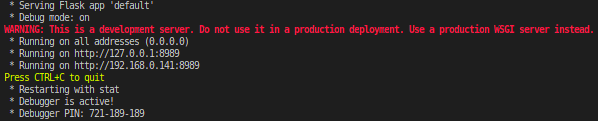

Quando este comando for executado, você deve receber a mensagem de que seu aplicativo está sendo executado no endereço http://0.0.0.0:8989/. Por enquanto, vamos ignorar um grande aviso vermelho e testar o aplicativo. Para verificar se o aplicativo está funcionando conforme o esperado, podemos enviar uma solicitação de teste (dados do aplicativo de empréstimo) para o aplicativo e ver se obtemos uma resposta (previsão de probabilidade padrão) em retorno.


```
# Example loan application
application = {
    "Term": 84,
    "NoEmp": 5,
    "CreateJob": 0,
    "RetainedJob": 5,
    "longitude": -77.9221,
    "latitude": 35.3664,
    "GrAppv": 1500000.0,
    "SBA_Appv": 1275000.0,
    "is_new": True,
    "FranchiseCode": "0",
    "UrbanRural": 1,
    "City": "Other",
    "State": "NC",
    "Bank": "BBCN BANK",
    "BankState": "CA",
    "RevLineCr": "N",
    "naics_first_two": "45",
    "same_state": False,
}

# Location of my server
url = "http://0.0.0.0:8989/predict"

# Send request
resp = requests.post(url, json=application)

# Print result
print(resp.json())
```


Se você conseguiu obter uma resposta com probabilidade - parabéns! 

Você implantou o modelo usando seu próprio computador como servidor. Agora, vamos acelerar e empacotar seu aplicativo de implantação usando o `Docker`.

# Conteinerização de Flask App

A `conteinerização` é o processo de `encapsular seu aplicativo` e todas as suas dependências (incluindo Python) em um pacote independente e isolado que pode ser executado de forma consistente em diferentes ambientes (<font color="red">por exemplo:</font> localmente, na nuvem, no laptop de seu amigo, etc.). Você pode conseguir isso com o `Docker` e tudo o que precisa fazer é especificar corretamente o `Dockerfile`, criar a imagem e executá-la. O `Dockerfile` fornece instruções ao seu contêiner, <font color="yellow">por exemplo:</font> qual versão do Python usar, quais pacotes instalar e quais comandos executar. Há um ótimo tutorial em vídeo de [Abhishek Thakur](https://www.youtube.com/watch?v=0qG_0CPQhpg&t=138s) sobre o Docker se você estiver interessado em saber mais.

Veja como pode ser a aparência do `Aplicativo Flask` abaixo:

```
# Imagem base Python 3.9
FROM python:3.9-slim

# Definimos nosso diretório de trabalho
WORKDIR /app

# Copie o arquivo requirements.txt para dentro do contêiner
COPY requirements.txt requirements.txt

# Instalamos as bibliotecas necessárias
RUN pip install --upgrade pip
RUN pip install -r requirements.txt

# Copie o modelo e o código do aplicativo no contêiner
COPY ["loan_catboost_model.cbm", "app.py", "./"] .

# Execute o aplicativo (app) usando gunicorn
ENTRYPOINT [ "gunicorn", "--bind=0.0.0.0:8989", "app:app" ]
```


Agora, podemos construir a imagem usando o comando `docker build`, assim:


```
docker build -t flask-server:v01 .
```


Onde: `-t` dá a você a opção de nomear sua imagem docker e fornecer uma `tag` para ela, então o nome desta imagem é `flask-server` com uma tag de `v01`. `O ponto` no final refere-se ao argumento `PATH` que precisa ser fornecido. É a localização do seu modelo, código do aplicativo, etc. Como presumo que você esteja construindo esta imagem no diretório com todo o código, `PATH` é definido como o `.` que significa diretório atual. Pode levar algum tempo para criar essa imagem, mas, depois de concluída, você poderá vê-la ao executar o comando `docker images`.


Vamos executar o aplicativo Dockerizado usando o seguinte comando:

```
docker run -it --rm -p 8989:8989 flask-server:v01
```


Onde: a flag `-it` faz com que a imagem do Docker seja executada em um `modo interativo`, o que significa que você poderá ver os `logs` de código no shell e interromper a imagem quando necessário usando `Ctrl+C`. `--rm` garante que o contêiner seja removido automaticamente quando você parar a imagem. Por fim, `-p` disponibiliza as portas de dentro da imagem do Docker para fora dela. O comando acima mapeia a `porta 8989` de dentro do Docker para o `localhost`, disponibilizando nosso endpoint no mesmo endereço.


# Testando Flask App

Agora que nosso modelo foi implantado com sucesso usando o `Flask` e o `contêiner de implantação` está funcionando (pelo menos localmente), é hora de <font color="pink">avaliar seu desempenho</font>. Neste ponto, nosso foco está em servir métricas como tempo de resposta e a capacidade do servidor de lidar com `solicitações (requests) por segundo`, em vez de métricas de ML como Root Mean Squared Error (`RMSE`) ou `F1 score`.

# Testando Usando um Script

Para obter uma estimativa aproximada da `latência de resposta`, podemos criar um script que envia várias solicitações ao servidor e medir o tempo (`geralmente em milissegundos`) que o servidor leva para retornar uma previsão. No entanto, é importante observar que o **tempo de resposta não é constante**, portanto, precisamos medir a `latência média` para estimar o tempo que os usuários geralmente esperam para receber uma resposta e o `95º` percentil de latência para medir os piores cenários.

```
import requests
import time
import numpy as np
from tqdm import tqdm

if __name__ == "__main__":
    # Example loan application
    application = {
        "Term": 84,
        "NoEmp": 5,
        "CreateJob": 0,
        "RetainedJob": 5,
        "longitude": -77.9221,
        "latitude": 35.3664,
        "GrAppv": 1500000.0,
        "SBA_Appv": 1275000.0,
        "is_new": True,
        "FranchiseCode": "0",
        "UrbanRural": 1,
        "City": "Other",
        "State": "NC",
        "Bank": "BBCN BANK",
        "BankState": "CA",
        "RevLineCr": "N",
        "naics_first_two": "45",
        "same_state": False,
    }

    # Location of my server
    url = "http://0.0.0.0:8989/predict"

    # Measure the response time
    all_times = []
    # For 1000 times
    for i in tqdm(range(1000)):
        t0 = time.time_ns() // 1_000_000
        # Send a request
        resp = requests.post(url, json=application)
        t1 = time.time_ns() // 1_000_000
        # Measure how much time it took to get a response in ms
        time_taken = t1 - t0
        all_times.append(time_taken)

    # Print out the results
    print("Response time in ms:")
    print("Median:", np.quantile(all_times, 0.5))
    print("95th precentile:", np.quantile(all_times, 0.95))
    print("Max:", np.max(all_times))
```

Para executar este código (`response_latency.py`) que mede esta métrica de Latência, simplesmente passamos o seguinte comando:

```
python response_latency.py
```




O tempo médio de resposta (`The median response time`) acabou sendo `3ms`, mas o pior cenário é mais de 10x este tempo. Se esse desempenho é satisfatório ou não, depende de você e do gerente de produto, mas pelo menos agora você está ciente dessas métricas e pode trabalhar mais para melhorá-las.

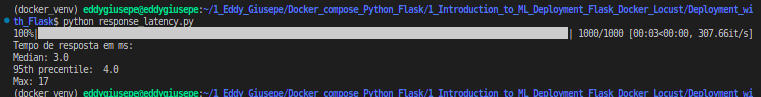

# Testando usando o Locust

[Locust](https://docs.locust.io/en/stable/what-is-locust.html) é um `pacote Python` projetado para testar o `desempenho` (performance) e a `escalabilidade` de aplicativos da Web. Vamos usar o `Locust` para gerar um cenário de teste mais avançado, pois permite configurar parâmetros como o `número de usuários` (ou seja, solicitantes de empréstimo) por segundo.

Em primeiro lugar, o pacote pode ser instalado executando `pip install locust` em seu terminal. Em seguida, precisamos definir um cenário de teste que especificará o que nosso usuário imaginário fará com nosso servidor. No nosso caso é bastante simples — o usuário nos enviará uma solicitação com as informações (`formatadas em json`) sobre seu pedido de empréstimo e receberá uma resposta de nosso modelo implantado.

```
from locust import HttpUser, task, constant_throughput

# Define test json request
test_application = {
        "Term": 84,
        "NoEmp": 5,
        "CreateJob": 0,
        "RetainedJob": 5,
        "longitude": -77.9221,
        "latitude": 35.3664,
        "GrAppv": 1500000.0,
        "SBA_Appv": 1275000.0,
        "is_new": True,
        "FranchiseCode": "0",
        "UrbanRural": 1,
        "City": "Other",
        "State": "NC",
        "Bank": "BBCN BANK",
        "BankState": "CA",
        "RevLineCr": "N",
        "naics_first_two": "45",
        "same_state": False,
    }

class BankLoan(HttpUser):
    # Means that a user will send 1 request per second
    wait_time = constant_throughput(1)
    
    # Task to be performed (send data & get response)
    @task
    def predict(self):
        self.client.post(
            "/predict",
            json=test_application,
            timeout=1,
        )
```



Como você pode ver, a tarefa do `Locust` é muito semelhante a um `ping de teste` que fizemos acima. A única diferença é que ele precisa ser agrupado em uma `classe herdada` `locust.HttpUser` e a tarefa executada (enviar dados e obter resposta) precisa ser decorada com `@task`.

Para iniciar o `teste de carga`, basta executar o comando abaixo.

```
locust -f testing_App_with_Locust.py
```


Quando ele for iniciado, você poderá acessar a `IU de teste` em http://0.0.0.0:8089 onde precisará especificar a `URL do aplicativo`, o `número de usuários` e a `taxa de geração` (spawn rate).

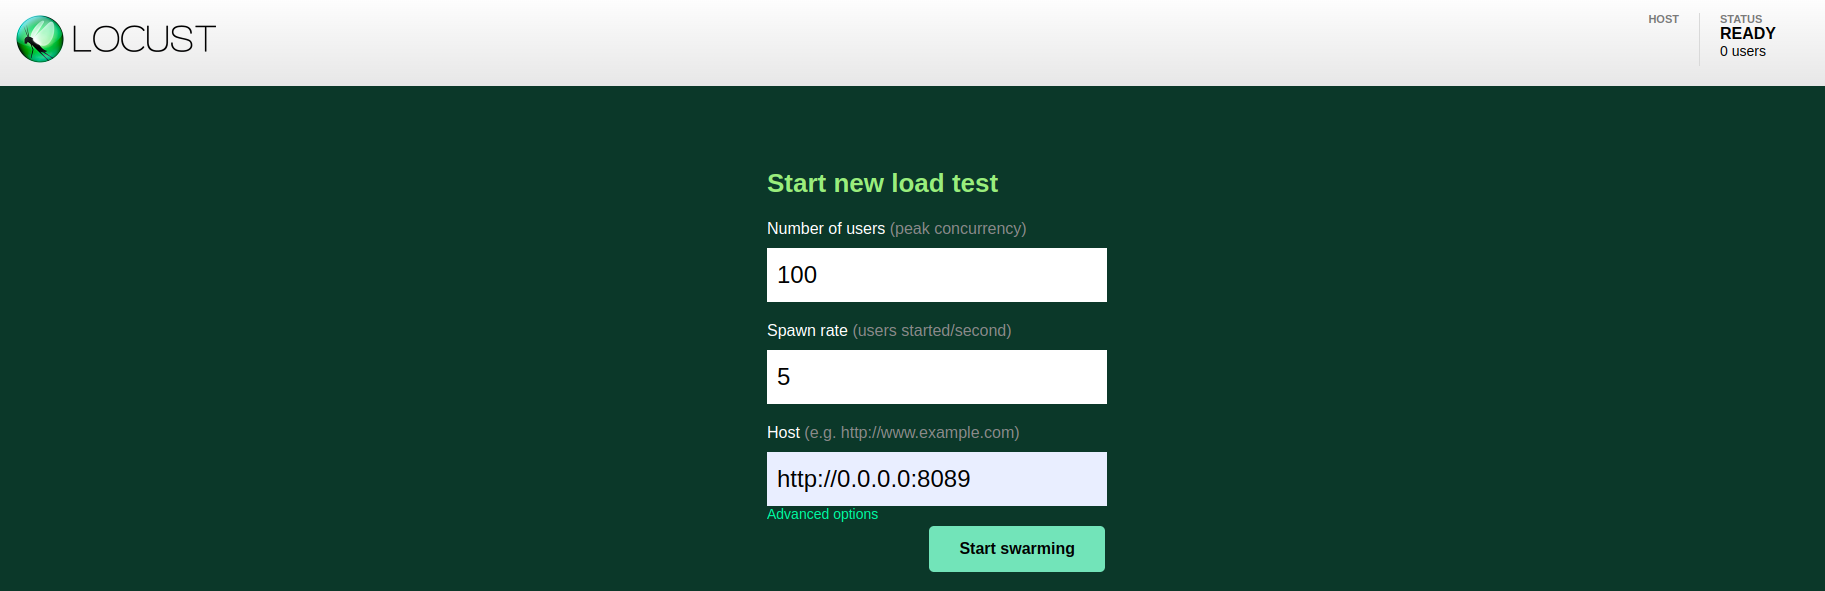

Taxa de geração (`Spawn rate`) de `5` e com `100` usuários significa que a cada segundo haverá `5` novos usuários enviando solicitações para seu aplicativo, até que o número chegue a `100`. Isso significa que, no pico, nosso aplicativo precisará lidar com `100` solicitações por segundo. Agora, vamos clicar no botão Iniciar enxame (`Start swarming`) e ir para a seção de gráficos da `IU`. A seguir, apresentarei os resultados da minha máquina, mas eles certamente serão diferentes da sua, portanto, certifique-se de executar isso por conta própria também.

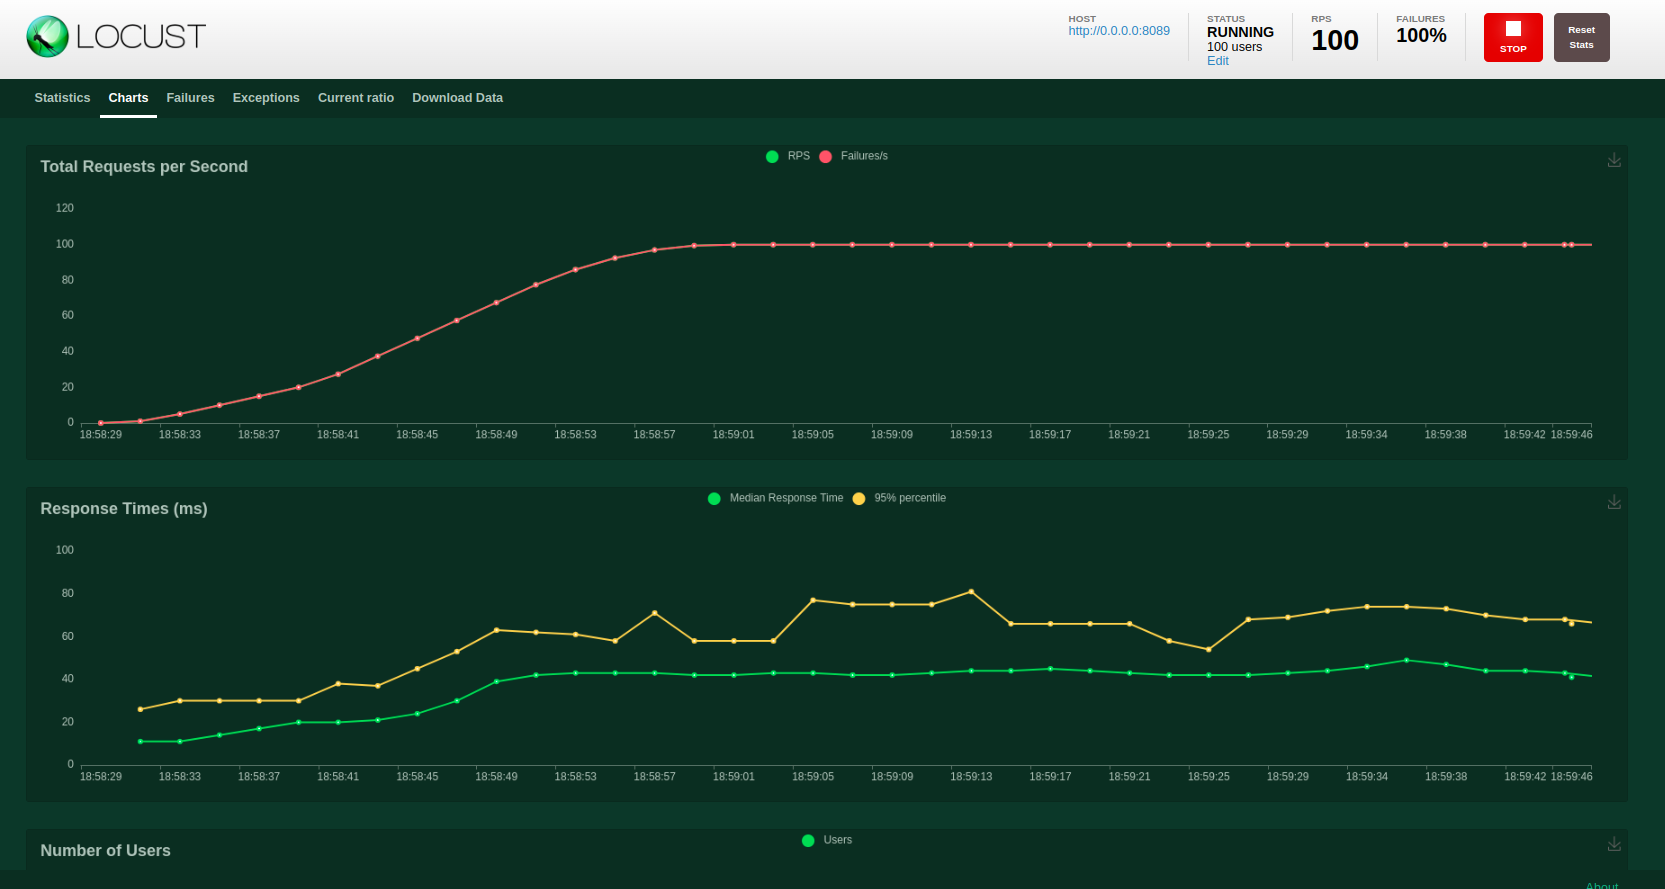

Você verá que, à medida que o tráfego aumenta, seu tempo de resposta ficará mais lento. Haverá alguns picos ocasionais também, por isso é importante entender quando eles acontecem e por quê. Mais importante ainda, o Locust nos ajuda a entender que nosso servidor local pode lidar com $100$ solicitações por segundo com tempo médio de resposta de aproximadamente `250 ms`.

Podemos continuar testando nosso aplicativo e identificar a carga que ele não consegue gerenciar. Para isso, vamos aumentar o número de usuários para `1000` para ver o que acontece.

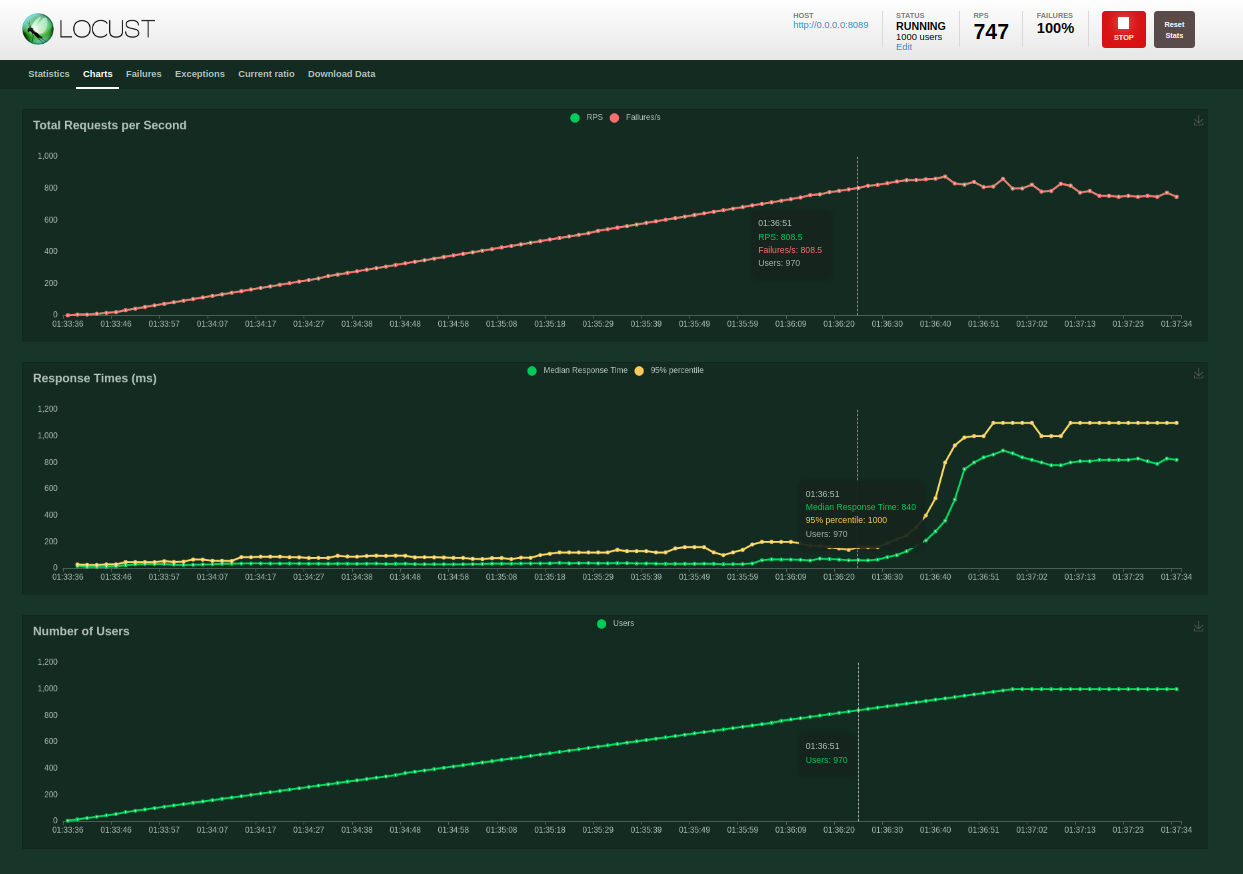

Parece que o ponto de interrupção do meu servidor local é de aproximadamente $180$ (verificar este valor) usuários simultâneos. Essa é uma informação importante que conseguimos extrair usando o Locust.